In [111]:
# %matplotlib notebook
%matplotlib inline
from ipynb_setup import *
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

import os
import re

In [112]:
from utils.file_utils import get_experiment_df, get_experiment_configs_df
from utils.path_utils import visuals_folder
from plotlib.performance_plots import plot_standard_dev

In [113]:
sns.set_style("whitegrid")

## Path Selection

In [203]:
base_paths = []
full_data_paths = []

# CIFAR-10
# base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/cifar10/active-cifar10_low/batchbald_mini_exp"))
# base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/cifar10/active-cifar10_low"))
# base_path = Path("/mnt/drive_nvme2/logs_cluster")
# base_path = Path("/home/c817h/network/Cluster-Experiments")
# base_path = Path("/mnt/drive_nvme2/rsync_cluster")
# base_paths.append(Path(base_path/"activelearning/cifar10/active-cifar10_low"))
# base_paths.append(Path(base_path/"activelearning/cifar10/active-cifar10_med"))
# base_paths.append(Path(base_path/"activelearning/cifar10/active-cifar10_high"))

# full_data_paths.append(base_path/"activelearning/cifar10/full_data/basic_model-resnet_drop-0_aug-cifar_randaugmentMC_wd-0.0005_lr-0.1_optim-sgd_cosine")

# CIFAR-100
# base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/cifar100/active-cifar100_low-batchbald"))
# base_path = Path("/mnt/drive_nvme2/logs_cluster")
# base_path = Path("/home/c817h/network/Cluster-Experiments")
# base_paths.append(base_path /"activelearning/cifar100/active-cifar100_low")
# base_paths.append(base_path /"activelearning/cifar100/active-cifar100_med")
# base_paths.append(base_path /"activelearning/cifar100/active-cifar100_high")
# base_paths.append(base_path /"activelearning/cifar100/active-cifar100_low-batchbald")
# full_data_paths.append(base_path/ "activelearning/cifar100/full_data/basic_model-resnet_drop-0_aug-cifar_randaugmentMC_wd-0.005_lr-0.1_optim-sgd_cosine")

# cluster_path = Path("/home/c817h/network/Cluster-Experiments")
# base_paths.append(cluster_path/ "activelearning/cifar100/active-cifar100_low")
# base_paths.append(cluster_path/ "activelearning/cifar100/active-cifar100_med")
# base_paths.append(cluster_path/ "activelearning/cifar100/active-cifar100_high")


# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar100/active-standard"))
# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar100/active-cifar100"))


# CIFAR-10 imb
# base_path = Path("/home/c817h/network/Cluster-Experiments")
# base_paths.append(base_path / "activelearning/cifar10_imb/active-cifar10_low")
# base_paths.append(base_path / "activelearning/cifar10_imb/active-cifar10_med")
# base_paths.append(base_path / "activelearning/cifar10_imb/active-cifar10_high")

# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar10_imb/active-cifar10_low"))
# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar10_imb/active-cifar10_med"))
# base_paths.append(Path("/home/c817h/Documents/logs_cluster/activelearning/cifar10_imb/active-cifar10_high"))
# base_path = Path("/mnt/drive_nvme2/logs_cluster")
# base_paths.append(base_path/ "activelearning/cifar10_imb/active-cifar10_low")
# base_paths.append(base_path/ "activelearning/cifar10_imb/active-cifar10_med")
# base_paths.append(base_path/ "activelearning/cifar10_imb/active-cifar10_high")
# base_path = Path("/mnt/drive_nvme2/rsync_cluster")
# weighted_version
# full_data_paths.append(Path(base_path/"activelearning/cifar10_imb/full_data/basic_model-resnet_drop-0_aug-cifar_randaugmentMC_wd-0.0005_lr-0.1_optim-sgd_cosine_weighted-true"))
# unweighted_version
# full_data_paths.append(Path(base_path/"activelearning/cifar10_imb/full_data/basic_model-resnet_drop-0_aug-cifar_randaugmentMC_wd-0.005_lr-0.1_optim-sgd_cosine"))

# ISIC-2019
base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/isic2019/active-isic19_low"))
base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/isic2019/active-isic19_med"))
base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/isic2019/active-isic19_high"))
full_data_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/isic2019/full_data/basic_model-resnet_drop-0_aug-isic_train_wd-0.0005_lr-0.01"))

# Mio-TCD
# base_path = Path("/mnt/drive_nvme2/logs_cluster")
# base_paths.append(base_path /"activelearning/miotcd/active-miotcd_low")
# base_paths.append(base_path /"activelearning/miotcd/active-miotcd_med")
# base_paths.append(base_path /"activelearning/miotcd/active-miotcd_high")

# base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/miotcd/active-miotcd_low-batchbald"))
# base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/miotcd/active-miotcd_low"))
# base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/miotcd/active-miotcd_med"))
# base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/miotcd/active-miotcd_high"))
# base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/miotcd/active-miotcd_high_imbalance"))
# # preliminary!
# base_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/miotcd/ablation-dip"))
# full_data_paths.append(Path("/home/c817h/network/Cluster-Experiments/activelearning/miotcd/full_data/basic_model-resnet_drop-0_aug-imagenet_train_wd-0.0005_lr-0.1"))

## Run Selection

In [205]:
match_patterns = [
    r"basic_.*",
    r"basic-pretrained_.*",
#     r".*__wloss.*"
#     BB experiment
#     r".*bald.*"
#     r".*random.*"
#     r"fixmatch_.*",
#     r"fixmatch-pretrained_.*",
]

filter_patterns = [
    
#     r".*batchbald.*"
#     ".*wd-0.01_.*"
#     r".*kcenter.*",
#     r".*variationratios.*"
#     r".*batchbald.*"
#     r".*basic-pretrained_.*",
]

## Style and Color Selection

In [206]:
hue_name = "Acquisition"

hue_split = "acq-"

style_name = "PreTraining & Semi-Supervised"
style_fct = lambda x: "PT: {}, Sem-SL: {}".format(
    "pretrained_model" in x.name,
    "fixmatch" in x.name
)

unit_vals = None
unit_name = "Unit"

palette = {
    'bald': 'tab:blue',
    'kcentergreedy': 'tab:green',
    'entropy': 'tab:orange',
    'random': 'tab:red',
    'batchbald' : 'tab:cyan'
}

# Sadly does not Work!
# dashes = {
#     'PT: False, Sem-SL: False' : '--',
#     'PT: True, Sem-SL: False' : '-',
#     'PT: False, Sem-SL: True' : ':',
#     'PT: True, Sem-SL: True' : '-.',
# }

dashes = {
    'PT: False, Sem-SL: False' : (4, 4),
    'PT: True, Sem-SL: False' : (1, 0),
    'PT: False, Sem-SL: True' : (1, 2),
    'PT: True, Sem-SL: True' : (2, 1),
}

markers= True
# no color
# markers = {
#     'PT: False, Sem-SL: False' : "x",
#     'PT: True, Sem-SL: False' : "+",
#     'PT: False, Sem-SL: True' : "1",
#     'PT: True, Sem-SL: True' : "2",
# }

markers = {
    'PT: False, Sem-SL: False' : "v",
    'PT: True, Sem-SL: False' : "o",
    'PT: False, Sem-SL: True' : "D",
    'PT: True, Sem-SL: True' : "D",
}

err_kws = {
    "alpha" : 0.3
}

## Fetch Data

In [207]:
dfs = []

for base_path in base_paths:
    paths = [path for path in base_path.iterdir() if path.is_dir()]
    paths.sort()
    print("Folders in Path: \n {}\n".format(base_path))

    
    experiment_paths = []
    for path in paths:
#         print(path)
        for pattern in match_patterns:
#             print(path.name)
            out = re.match(pattern, str(path.name))
            if out is not None:
                print(path.name)
                skip = False
                for filter_pattern in filter_patterns:
                    if re.match(filter_pattern, str(path)) is not None:
                        skip=True
                if skip:
                    continue

                print(path.name)
                experiment_paths.append(path)
                continue
                    


    hue_names = [path.name.split(hue_split)[1].split('_')[0] for path in experiment_paths]#.split('_')[0] for path in paths]
    style_vals = [style_fct(path) for path in experiment_paths]


    df = []
    for i, (base_dir) in enumerate(experiment_paths):
        base_dir = Path(base_dir)
        if hue_names is not None:
            hue_val = hue_names[i]
        else:
            hue_val = None
        if style_vals is not None:
            style_val = style_vals[i]
        else:
            style_val = None
        if unit_vals is not None:
            unit_val = unit_vals[i]
        else:
            unit_val = None

        experiment_frame = get_experiment_df(base_dir, name=hue_val)
        # experiment_frame[hue_name] = hue_val
        if experiment_frame is None:
            continue
        
        # Add new metric values
        experiment_add = get_experiment_df(base_dir, pattern="test_metrics.csv", name=hue_val)
#         print(experiment_add)
        if experiment_add is not None:
#             print(experiment_frame)
#             print(experiment_add)
            del experiment_add["Name"]
            del experiment_add["version"]
            experiment_frame = experiment_frame.join(experiment_add)
#             print(experiment_frame)
        
        
        experiment_frame[hue_name] = hue_val
        experiment_frame[style_name] = style_val
        experiment_frame[unit_name] = unit_val
        df.append(experiment_frame)
    df = pd.concat(df)
    df.reset_index(inplace=True)

    dfs.append(df)

Folders in Path: 
 /home/c817h/network/Cluster-Experiments/activelearning/isic2019/active-isic19_low

basic-pretrained_model-resnet_drop-0.5_aug-isic_randaugment_acq-bald_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0.5_aug-isic_randaugment_acq-bald_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0.5_aug-isic_randaugment_acq-batchbald_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0.5_aug-isic_randaugment_acq-batchbald_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-isic_randaugment_acq-entropy_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-isic_randaugment_acq-entropy_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-isic_randaugment_acq-kcentergreedy_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-isic_randaugment_acq-kcentergreedy_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug

Loading Experiment: /home/c817h/network/Cluster-Experiments/activelearning/isic2019/active-isic19_med/basic_model-resnet_drop-0.5_aug-isic_randaugmentMC_acq-bald_ep-200
Found num files: 3
Loading Experiment: /home/c817h/network/Cluster-Experiments/activelearning/isic2019/active-isic19_med/basic_model-resnet_drop-0.5_aug-isic_randaugmentMC_acq-bald_ep-200
Found num files: 3
Loading Experiment: /home/c817h/network/Cluster-Experiments/activelearning/isic2019/active-isic19_med/basic_model-resnet_drop-0_aug-isic_randaugmentMC_acq-entropy_ep-200
Found num files: 3
Loading Experiment: /home/c817h/network/Cluster-Experiments/activelearning/isic2019/active-isic19_med/basic_model-resnet_drop-0_aug-isic_randaugmentMC_acq-entropy_ep-200
Found num files: 3
Loading Experiment: /home/c817h/network/Cluster-Experiments/activelearning/isic2019/active-isic19_med/basic_model-resnet_drop-0_aug-isic_randaugmentMC_acq-kcentergreedy_ep-200
Found num files: 3
Loading Experiment: /home/c817h/network/Cluster-Exp

In [208]:
full_data_dict = {}

for path in full_data_paths:
    test_acc_df = pd.read_csv(path/"test_acc.csv", index_col=0)
    full_data_dict["test_acc"]=dict()
    full_data_dict["test_acc"]["mean"] = float(test_acc_df["Mean"])
    full_data_dict["test_acc"]["std"] =  float(test_acc_df["STD"])
    
    if (path/"test_w_acc.csv").is_file():
        mean_recall_df = pd.read_csv(path/"test_w_acc.csv", index_col=0)
        full_data_dict["test/w_acc"]=dict()
        full_data_dict["test/w_acc"]["mean"] = float(mean_recall_df["Mean"])
        full_data_dict["test/w_acc"]["std"] =  float(mean_recall_df["STD"])

## Create Plot

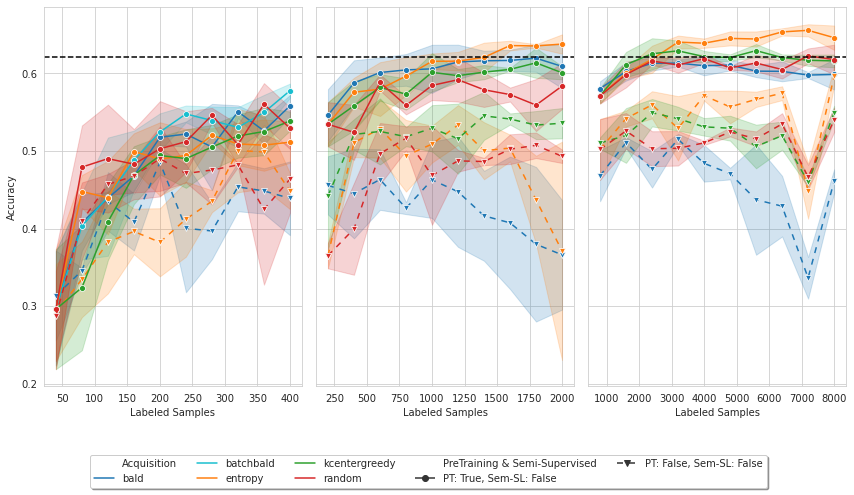

In [209]:
num_cols = len(dfs)
ax_legend = 0
fig, axs = plt.subplots(ncols=num_cols, sharey=True)
if num_cols == 1:
    axs = [axs]
if style_vals is None:
    style_name = None
if unit_vals is None:
    unit_name = None

for i in range(num_cols):
    df = dfs[i]
    ax = axs[i]
  
    legend = False
    if i == ax_legend:
        legend = 'auto'
    ax = plot_standard_dev(
        ax, df, hue=hue_name, style=style_name, units=unit_name, ci = 'sd', legend=legend , palette=palette, markers=markers,
        dashes=dashes,
        err_kws={"alpha":0.2}
    )  # , units=unit_name)
    try:
        ax.axhline(full_data_dict["test_acc"]["mean"]/100, color="black", linestyle='--')
    except:
        pass
    ax.set_xlabel("Labeled Samples")
    ax.set_ylabel("Accuracy")
    if i == ax_legend:
        ax.get_legend().remove()
# fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

fig.set_size_inches(12, 6)
fig.tight_layout()
plt.show()

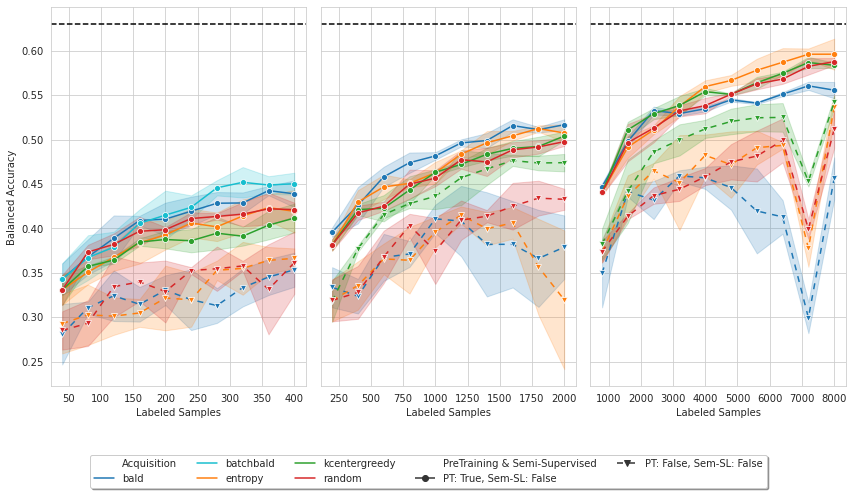

In [210]:
if 'test/w_acc' in dfs[0]:
    num_cols = len(dfs)
    ax_legend = 0
    fig, axs = plt.subplots(ncols=num_cols, sharey=True)
    if num_cols == 1:
        axs = [axs]
    if style_vals is None:
        style_name = None
    if unit_vals is None:
        unit_name = None

    for i in range(num_cols):
        df = dfs[i]
        ax = axs[i]

        legend = False
        if i == ax_legend:
            legend = 'auto'
        ax = plot_standard_dev(
            ax, df, hue=hue_name, style=style_name, units=unit_name, y='test/w_acc',ci = 'sd', legend=legend , palette=palette, markers=markers, 
            dashes=dashes
        )  # , units=unit_name)
        try:
            ax.axhline(full_data_dict["test/w_acc"]["mean"]/100, color="black", linestyle='--')
        except:
            pass

        ax.set_xlabel("Labeled Samples")
        ax.set_ylabel("Balanced Accuracy")
        if i == ax_legend:
            ax.get_legend().remove()
    # fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
    #           ncol=3, fancybox=True, shadow=True)
    # fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)

    fig.set_size_inches(12, 6)
    fig.tight_layout()
    plt.show()

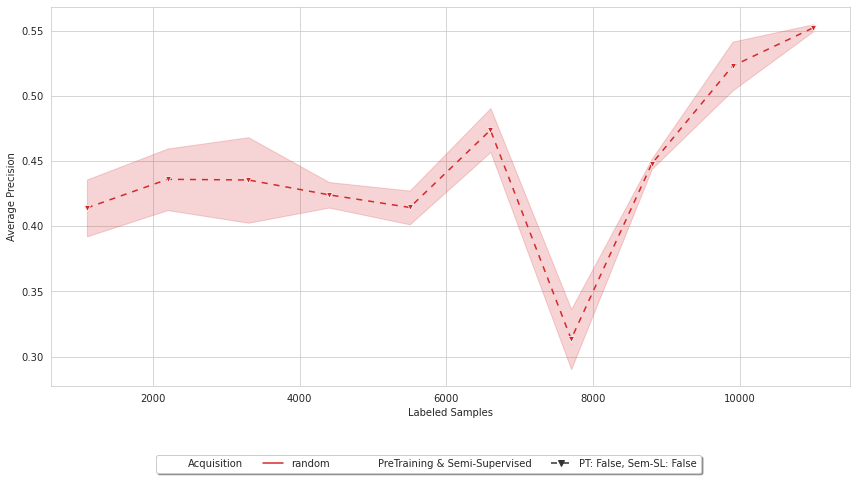

In [185]:
if 'test/av_f1' in dfs[0]:
    num_cols = len(dfs)
    ax_legend = 0
    fig, axs = plt.subplots(ncols=num_cols, sharey=True)
    if num_cols == 1:
        axs = [axs]
    if style_vals is None:
        style_name = None
    if unit_vals is None:
        unit_name = None

    for i in range(num_cols):
        df = dfs[i]
        ax = axs[i]

        legend = False
        if i == ax_legend:
            legend = 'auto'
        ax = plot_standard_dev(
            ax, df, hue=hue_name, style=style_name, units=unit_name, y='test/av_prec',ci = 'sd', legend=legend , palette=palette, markers=markers, 
            dashes=dashes
        )  # , units=unit_name)
        try:
            ax.axhline(full_data_dict["test/w_acc"]["mean"]/100, color="black", linestyle='--')
        except:
            pass

        ax.set_xlabel("Labeled Samples")
        ax.set_ylabel("Average Precision")
        if i == ax_legend:
            ax.get_legend().remove()
    # fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
    #           ncol=3, fancybox=True, shadow=True)
    # fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)

    fig.set_size_inches(12, 6)
    fig.tight_layout()
    plt.show()

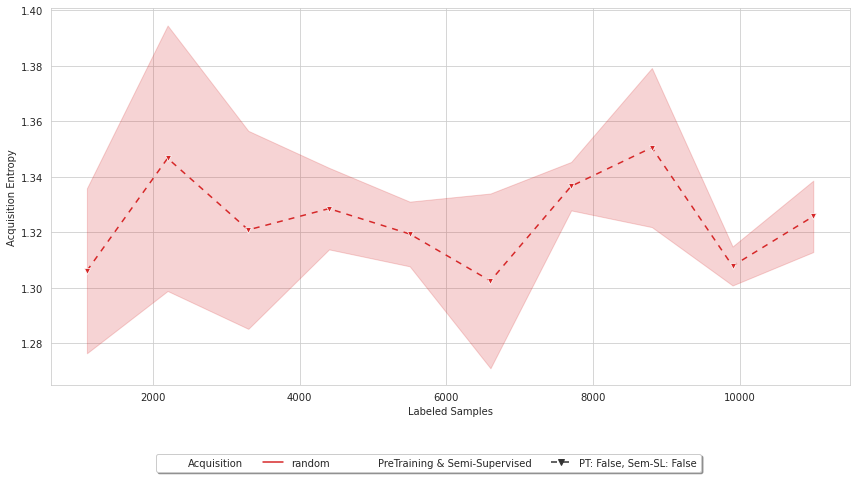

In [186]:
num_cols = len(dfs)
ax_legend = 0
fig, axs = plt.subplots(ncols=num_cols, sharey=True)
if num_cols == 1:
    axs = [axs]
if style_vals is None:
    style_name = None
if unit_vals is None:
    unit_name = None

for i in range(num_cols):
    df = dfs[i]
    ax = axs[i]
  
    legend = False
    if i == ax_legend:
        legend = 'auto'
    ax = plot_standard_dev(
        ax, df, hue=hue_name, style=style_name, units=unit_name, ci = 'sd', y='Acquisition Entropy', 
        legend=legend , palette=palette, markers=markers, 
            dashes=dashes
    )  # , units=unit_name)
    ax.set_xlabel("Labeled Samples")
    ax.set_ylabel("Acquisition Entropy")
    if i == ax_legend:
        ax.get_legend().remove()
# fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

fig.set_size_inches(12, 6)
fig.tight_layout()
plt.show()

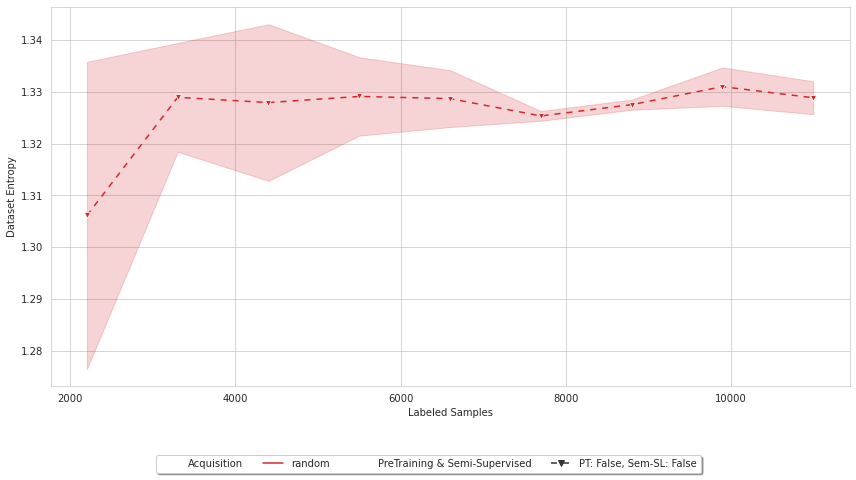

In [187]:
num_cols = len(dfs)
ax_legend = 0
fig, axs = plt.subplots(ncols=num_cols, sharey=True)
if num_cols == 1:
    axs = [axs]
if style_vals is None:
    style_name = None
if unit_vals is None:
    unit_name = None

for i in range(num_cols):
    df = dfs[i]
    ax = axs[i]
  
    legend = False
    if i == ax_legend:
        legend = 'auto'
    ax = plot_standard_dev(
        ax, df, hue=hue_name, style=style_name, units=unit_name, ci = 'sd', y='Dataset Entropy',
        legend=legend , palette=palette, markers=markers, 
        dashes=dashes
    )  # , units=unit_name)
    ax.set_xlabel("Labeled Samples")
    if i == ax_legend:
        ax.get_legend().remove()
# fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

fig.set_size_inches(12, 6)
fig.tight_layout()
plt.show()

In [188]:
dfs[0]

,index,val_acc,test_acc,num_samples,Acquisition Entropy,Dataset Entropy,version,Name,test/w_acc,test/av_prec,...,test/f1/cls_5,test/f1/cls_6,test/f1/cls_7,test/f1/cls_8,test/f1/cls_9,test/f1/cls_10,test/auroc,Acquisition,PreTraining & Semi-Supervised,Unit
0,0,0.687091,0.698469,1100,1.324237,NaN,9,random,0.509424,0.442932,...,0.256951,0.057646,0.483627,0.452976,0.168877,0.135963,0.880893,random,"PT: False, Sem-SL: False",None
1,0,0.687091,0.698469,1100,1.324237,NaN,9,random,0.492402,0.397156,...,0.129065,0.041327,0.425754,0.428232,0.125645,0.170633,0.851555,random,"PT: False, Sem-SL: False",None
2,0,0.687091,0.698469,1100,1.324237,NaN,9,random,0.461583,0.401933,...,0.060235,0.045752,0.386770,0.435050,0.135372,0.208181,0.830833,random,"PT: False, Sem-SL: False",None
3,0,0.625636,0.622062,1100,1.327563,NaN,9,random,0.509424,0.442932,...,0.256951,0.057646,0.483627,0.452976,0.168877,0.135963,0.880893,random,"PT: False, Sem-SL: False",None
4,0,0.625636,0.622062,1100,1.327563,NaN,9,random,0.492402,0.397156,...,0.129065,0.041327,0.425754,0.428232,0.125645,0.170633,0.851555,random,"PT: False, Sem-SL: False",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,9,0.662727,0.660731,11000,1.337592,1.332796,9,random,0.642011,0.549210,...,0.199452,0.049303,0.390351,0.522108,0.262857,0.233350,0.932448,random,"PT: False, Sem-SL: False",None
86,9,0.662727,0.660731,11000,1.337592,1.332796,9,random,0.639347,0.555380,...,0.216992,0.080469,0.474528,0.517440,0.270539,0.227004,0.935341,random,"PT: False, Sem-SL: False",None
87,9,0.674182,0.671872,11000,1.309064,1.328356,9,random,0.642921,0.551856,...,0.184507,0.086072,0.424111,0.535941,0.239313,0.230016,0.929537,random,"PT: False, Sem-SL: False",None
88,9,0.674182,0.671872,11000,1.309064,1.328356,9,random,0.642011,0.549210,...,0.199452,0.049303,0.390351,0.522108,0.262857,0.233350,0.932448,random,"PT: False, Sem-SL: False",None


In [189]:
from IPython.display import HTML

In [190]:
val_df = dfs[0].loc[:, [col for col in dfs[0].columns if "test/rec" in col or col =="num_samples"] ]
val_df
# dfs[0].columns[0]
HTML(val_df.groupby("num_samples").mean().to_html(classes='table table-stripped'))

,test/rec/cls_0,test/rec/cls_1,test/rec/cls_2,test/rec/cls_3,test/rec/cls_4,test/rec/cls_5,test/rec/cls_6,test/rec/cls_7,test/rec/cls_8,test/rec/cls_9,test/rec/cls_10
num_samples,,,,,,,,,,,
1100,0.404863,0.785874,0.606221,0.709542,0.646825,0.381234,0.142643,0.586947,0.550544,0.211957,0.339181
2200,0.450663,0.764577,0.598005,0.767712,0.540180,0.551181,0.173423,0.671704,0.600367,0.295290,0.435951
3300,0.511514,0.732793,0.684272,0.810850,0.507440,0.583333,0.193694,0.664258,0.531208,0.341097,0.425230
4400,0.405635,0.746847,0.708333,0.800523,0.419309,0.664698,0.225225,0.650898,0.509065,0.356108,0.473545
5500,0.389811,0.727692,0.734742,0.803137,0.447107,0.675853,0.214715,0.614104,0.490568,0.374224,0.433445
6600,0.489772,0.763277,0.740610,0.833725,0.506817,0.729659,0.283784,0.652431,0.550361,0.423395,0.494291
7700,0.210472,0.722007,0.680751,0.698562,0.314784,0.543307,0.151652,0.593517,0.343828,0.312888,0.242969
8800,0.454779,0.767011,0.747066,0.818824,0.474639,0.721129,0.226727,0.637976,0.537269,0.415631,0.496937
9900,0.487843,0.791743,0.789319,0.847974,0.552055,0.739501,0.252252,0.700832,0.625003,0.471015,0.554581


In [152]:
test = [x for x in range(10) if x%2 ==0]
test

[0, 2, 4, 6, 8]

## Obtain Numerical Results

In [ ]:
metric = "test_acc"

In [ ]:
df = dfs[0]
df_random = df[df["Name"]=="random"]
# df_random = df.loc[:, ["test_acc", "num_samples", "PreTraining & Semi-Supervised"]]

In [ ]:
for i in range(len(dfs)):
    df = dfs[i]
    df_random = df[df["Name"]=="random"]
    df_random = df_random.groupby(["num_samples", "PreTraining & Semi-Supervised"], ).agg({metric : ['mean', 'std']}).round(4)*100
    print(base_paths[i])
    print(df_random)